<a href="https://colab.research.google.com/github/ChenHieu170600/Stock-price-prediction-via-ensemble-learning-/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
%matplotlib inline

In [ ]:
df = pd.read_csv('price_train.csv')
df.head()

,date,open,high,low,close,volume,symbol
0,2021-01-04,17.05,17.70,16.90,17.55,46809600,STB
1,2021-01-05,17.55,17.95,17.45,17.70,23399500,STB
2,2021-01-06,17.90,18.35,17.70,18.00,32553600,STB
3,2021-01-07,18.05,18.45,17.85,18.45,40903700,STB
4,2021-01-08,18.80,19.50,18.65,19.40,36089200,STB


In [ ]:
df_test = pd.read_csv('price_test.csv')
df_test.head()

,date,symbol,close
0,2021-11-01,STB,NaN
1,2021-11-02,STB,NaN
2,2021-11-03,STB,NaN
3,2021-11-04,STB,NaN
4,2021-11-05,STB,NaN


In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,Id,Predicted
0,2021-11-01:BID,0.0
1,2021-11-02:BID,0.0
2,2021-11-03:BID,0.0
3,2021-11-04:BID,0.0
4,2021-11-05:BID,0.0


In [ ]:
data = [i for i in sub['Id'].str.split(':')]

df_test = pd.DataFrame(data, columns= ['Date', 'ID'])
df_test

,Date,ID
0,2021-11-01,BID
1,2021-11-02,BID
2,2021-11-03,BID
3,2021-11-04,BID
4,2021-11-05,BID
...,...,...
625,2021-11-23,VRE
626,2021-11-24,VRE
627,2021-11-25,VRE
628,2021-11-26,VRE


In [ ]:
def datetime_features(df):
  df = pd.DataFrame(df)
  df['date'] = pd.to_datetime(df['date'])
  df['month'] = df['date'].dt.month
  df['day']=df['date'].dt.dayofyear
  return df[['month','day']]

In [ ]:
make_datetime_features = FunctionTransformer(datetime_features)

In [ ]:
make_datetime_features.fit_transform(df)

,month,day
0,1,4
1,1,5
2,1,6
3,1,7
4,1,8
...,...,...
6144,10,298
6145,10,299
6146,10,300
6147,10,301


In [ ]:
X= df[['symbol','date']]
y = df['close']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.3)

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
ct = make_column_transformer((ohe, ['symbol']), 
                             (make_datetime_features, ['date']))

In [ ]:
X_train_transformed = ct.fit_transform(X_train).toarray()
X_test_transformed = ct.fit_transform(X_test).toarray()


In [ ]:
xgb_reg = XGBRegressor(n_estimator= 5000, learning_rate=0.04,
                       random_state = 1,
                       n_jobs=-1)
xgb_reg.fit(X_train_transformed,y_train)

[06:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.04, n_estimator=5000, n_jobs=-1, random_state=1)

In [ ]:
result = permutation_importance(estimator =xgb_reg, 
                                X=X_test_transformed, y=y_test,
                                scoring= 'neg_mean_absolute_percentage_error',
                                n_repeats= 60,
                                random_state= 1,
                                n_jobs=-1)


In [ ]:
result.importances_mean

array([ 0.        ,  0.        ,  0.        ,  0.00827447,  0.01441323,
        0.00694376,  0.        ,  0.        ,  0.00505134,  0.03596419,
        0.05001255,  0.02237814,  0.00142085,  0.        ,  0.01465149,
        0.06166215,  0.        ,  0.02160623,  0.        ,  0.01491859,
        0.        ,  0.0212081 ,  0.00252996,  0.02206845,  0.02287822,
        0.03056266,  0.04125407,  0.01526478,  0.        ,  0.00442747,
       -0.00014947,  0.00178844])

In [ ]:
result.importances_std

array([0.        , 0.        , 0.        , 0.00088849, 0.00166758,
       0.00059084, 0.        , 0.        , 0.00038346, 0.0032148 ,
       0.00473602, 0.00244314, 0.00024613, 0.        , 0.00149422,
       0.00237735, 0.        , 0.00149423, 0.        , 0.00098828,
       0.        , 0.00156559, 0.0002861 , 0.0022497 , 0.00219834,
       0.00278814, 0.00383629, 0.00154402, 0.        , 0.00053487,
       0.00012048, 0.00054827])

In [ ]:
feature_names = ct.transformers_[0][1].categories_[0]
feature_names

array(['BID', 'BVH', 'CTG', 'FPT', 'GAS', 'HDB', 'HPG', 'KDH', 'MBB',
       'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'REE', 'SBT',
       'SSI', 'STB', 'TCB', 'TCH', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE'], dtype=object)

In [ ]:
feature_labels = np.r_[feature_names, ['month','day']]
feature_labels

array(['BID', 'BVH', 'CTG', 'FPT', 'GAS', 'HDB', 'HPG', 'KDH', 'MBB',
       'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'REE', 'SBT',
       'SSI', 'STB', 'TCB', 'TCH', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC',
       'VNM', 'VPB', 'VRE', 'month', 'day'], dtype=object)

In [ ]:
sorted_indices = result['importances_mean'].argsort()
sorted_indices

array([30,  0,  1,  2, 28, 20, 18,  6,  7, 16, 13, 12, 31, 22, 29,  8,  5,
        3,  4, 14, 19, 27, 21, 17, 23, 11, 24, 25,  9, 26, 10, 15])

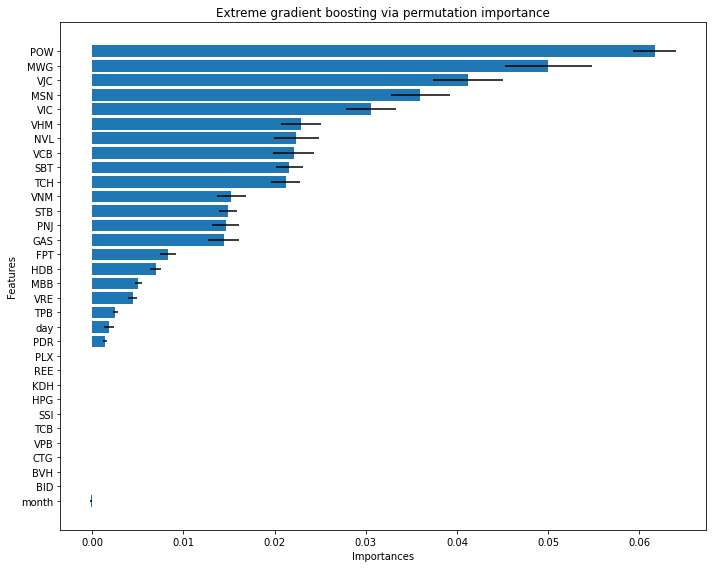

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Extreme gradient boosting via permutation importance')
plt.barh(
    feature_labels[sorted_indices],
    result['importances_mean'][sorted_indices],
    xerr= result['importances_std'][sorted_indices]
)
plt.ylabel('Features')
plt.xlabel('Importances')

plt.tight_layout()
plt.show()

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
ct = make_column_transformer((ohe, ['symbol']), 
                             (make_datetime_features, ['date']))

In [ ]:
xgb_reg = XGBRegressor(n_estimators=5000, 
                       learning_rate=0.04, 
                       random_state=1, n_jobs=-1)

# model 2
tree_1 = DecisionTreeRegressor(max_depth=None, random_state=2)
bag_reg = BaggingRegressor(base_estimator=tree_1, 
                           n_estimators=5000, 
                           random_state=1)

# model 3
forest_reg = RandomForestRegressor(n_estimators=5000, 
                                   random_state=2)

# model 4
linreg = LinearRegression()

# model 5
tweed = TweedieRegressor(power=1, alpha=0.1, link='log')

# model 6
tree_2 = DecisionTreeRegressor(max_depth=None, random_state=2)
ada_boost_reg = AdaBoostRegressor(base_estimator=tree_2, 
                                  learning_rate=0.2,
                                  random_state=1, 
                                  n_estimators=5000)

# model 7
mlp_reg = MLPRegressor(random_state=1, 
                       max_iter=234, 
                       hidden_layer_sizes=(15000,))

# model 8
gradient_boost_reg = GradientBoostingRegressor(random_state=0, 
                                               n_estimators=5000)

# model 9
estimators = [('lr', xgb_reg), 
              ('svr', LinearSVR(random_state=42))]

stacking_reg = StackingRegressor(estimators=estimators, 
                                 final_estimator=RandomForestRegressor(n_estimators=5000,
                                                                       random_state=42))

# model 10
extra_tree = ExtraTreesRegressor(n_estimators=5000, 
                                 random_state=0)

# model 11
hist_boost_reg = HistGradientBoostingRegressor(learning_rate=0.5,
                                               max_iter=1000)


# prepare a scaler for doing scaling after the step of transformation in the pipeline
scaler = StandardScaler(with_mean=False)



#############################################################################################
################################## make pipelines ###########################################

pipe_1 = make_pipeline(ct, scaler, xgb_reg)
pipe_2 = make_pipeline(ct, bag_reg)
pipe_3 = make_pipeline(ct, forest_reg)
pipe_4 = make_pipeline(ct, scaler, linreg)
pipe_5 = make_pipeline(ct, scaler, tweed)
pipe_6 = make_pipeline(ct, ada_boost_reg)
pipe_7 = make_pipeline(ct, scaler, mlp_reg)
pipe_8 = make_pipeline(ct, scaler, gradient_boost_reg)
pipe_9 = make_pipeline(ct, stacking_reg)
pipe_10 = make_pipeline(ct, extra_tree)

In [ ]:
features = ['date', 'symbol']
X_test = df_test[features]

In [ ]:
# model 1: xgboost
pipe_1.fit(X, y)
y_pred_1 = pipe_1.predict(X_test)
print('Model 1: Done')

# model 2: bagging
pipe_2.fit(X, y)
y_pred_2 = pipe_2.predict(X_test)
print('Model 2: Done')

# model 3: random forests
pipe_3.fit(X, y)
y_pred_3 = pipe_3.predict(X_test)
print('Model 3: Done')

# model 4: linear regression
pipe_4.fit(X, y)
y_pred_4 = pipe_4.predict(X_test)
print('Model 4: Done')

# model 5: tweed
pipe_5.fit(X, y)
y_pred_5 = pipe_5.predict(X_test)
print('Model 5: Done')

# model 6: adaboost
pipe_6.fit(X, y)
y_pred_6 = pipe_6.predict(X_test)
print('Model 6: Done')

# model 7: mlp
pipe_7.fit(X, y)
y_pred_7 = pipe_7.predict(X_test)
print('Model 7: Done')

# model 8: gradient boosting 
pipe_8.fit(X, y)
y_pred_8 = pipe_8.predict(X_test)
print('Model 8: Done')

# model 9: stacking 
pipe_9.fit(X, y)
y_pred_9 = pipe_9.predict(X_test)
print('Model 9: Done')

# model 10: extra tree
pipe_10.fit(X, y)
y_pred_10 = pipe_10.predict(X_test)
print('Model 10: Done')

# model 11: hist
X = ct.fit_transform(X).toarray()
X_test = ct.transform(X_test).toarray()

hist_boost_reg.fit(X, y)
y_pred_11 = hist_boost_reg.predict(X_test)
print('Model 11: Done')

[06:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model 1: Done
Model 2: Done
Model 3: Done
Model 4: Done
Model 5: Done
Model 6: Done
Model 7: Done
Model 8: Done
[07:20:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[07:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:21:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:21:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:21:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Model 9: Done
